In [2]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('./')
        print(f"✅ Extracted: {filename}")

os.listdir('./')


Saving waste_classifier.zip to waste_classifier.zip
✅ Extracted: waste_classifier.zip


['.config', 'waste_classifier.zip', 'waste_classifier', 'sample_data']

In [12]:
import cv2
import numpy as np
import tensorflow as tf

model_path = '/content/waste_classifier/waste_classifier.keras'
model = tf.keras.models.load_model(model_path)

def predict_image(frame):
    img = cv2.resize(frame, (150, 150))
    img_array = img / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return predicted_class

class_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'plastic'}

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    height, width, _ = frame.shape
    roi = frame[height//4:height*3//4, width//4:width*3//4]

    predicted_class = predict_image(roi)
    waste_type = class_labels.get(predicted_class, 'Unknown')

    cv2.rectangle(frame, (width//4, height//4), (width*3//4, height*3//4), (255, 0, 0), 2)
    cv2.putText(frame, f'Waste Type: {waste_type}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Waste Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


<IPython.core.display.Javascript object>

⚠️ Image not yet available. Wait a second and run cv2.imread(filename) again.
✅ Photo saved as: photo.jpg


Original image shape (H,W,C): (480, 640, 3)


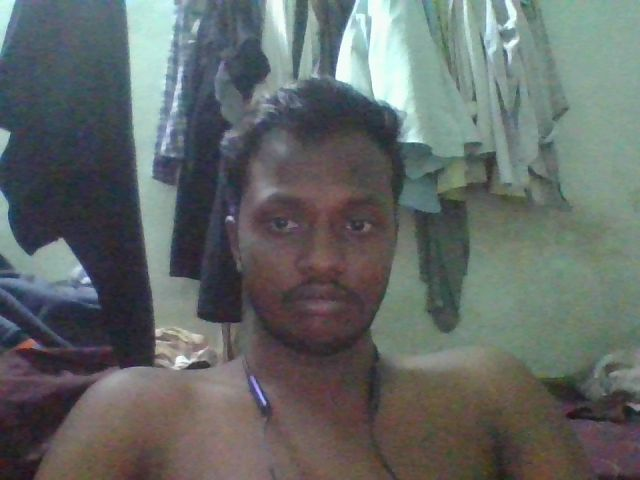

Model loaded. Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,910,993 (121.73 MB)

 Trainable params: 10,636,997 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,273,996 (81.15 MB)

Model.input_shape: (None, 150, 150, 3)
Preparing image to: 150x150, channels=3
Preprocessed image shape (batch,H,W,C): (1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Raw model output shape: (1, 5)
Predicted class index: 1
Probabilities: [0.17538624 0.3584279  0.15405184 0.15425463 0.15787949]
Predicted: glass (confidence: 0.358)
Top predictions:
 - glass: 0.358
 - cardboard: 0.175
 - Class_4: 0.158


In [19]:
import cv2
import numpy as np
import tensorflow as tf
import os

# === USER ADJUST if required ===
model_path = '/content/waste_classifier/waste_classifier.keras'   # update if different
image_path = '/content/photo.jpg'  # the captured image

# === 1) Load image and check ===
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found or unreadable at: {image_path}. Check path and that the file exists.")
print("Original image shape (H,W,C):", None if img is None else img.shape)

# show a small preview (Colab)
try:
    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
except Exception:
    pass

# === 2) Load model and inspect input shape ===
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}. Put the correct path to your .keras file.")
model = tf.keras.models.load_model(model_path)
print("Model loaded. Summary:")
model.summary()  # prints layers and shapes

# Determine expected input shape (batch, H, W, C) or (batch, C, H, W)
input_shape = model.input_shape
print("Model.input_shape:", input_shape)

# === 3) Preprocessing helper based on model input shape ===
# Determine target height,width,channels
# input_shape might be like (None, 150, 150, 3) or (None, None, None, 3)
if len(input_shape) == 4:
    _, h, w, c = input_shape
elif len(input_shape) == 3:
    # sometimes models expect (H,W,C) without batch dim in signature
    h, w, c = input_shape
else:
    # fallback to common default
    h, w, c = 150, 150, 3

if h is None: h = 150
if w is None: w = 150
if c is None: c = 3

h, w, c = int(h), int(w), int(c)
print(f"Preparing image to: {h}x{w}, channels={c}")

# Convert BGR (OpenCV) -> RGB if model likely trained on RGB
# Heuristic: if model expects 3 channels, convert to RGB; if 1, convert to grayscale.
if c == 3:
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
elif c == 1:
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    # If model expects different channels (rare), try to convert to RGB and then adapt
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize and normalize
img_resized = cv2.resize(img_proc, (w, h), interpolation=cv2.INTER_AREA)
# if grayscale, ensure shape is (h,w,1)
if c == 1:
    img_resized = np.expand_dims(img_resized, axis=-1)
img_array = img_resized.astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch axis

print("Preprocessed image shape (batch,H,W,C):", img_array.shape)

# === 4) Predict and show probabilities ===
preds = model.predict(img_array)
print("Raw model output shape:", preds.shape)

# If model returns logits for multiclass, apply softmax
if preds.ndim == 2 and preds.shape[1] > 1:
    probs = tf.nn.softmax(preds[0]).numpy()
    # class index = argmax
    idx = int(np.argmax(probs))
else:
    # Binary or single-output model
    probs = preds[0]
    if probs.size == 1:
        # single sigmoid output -> threshold at 0.5
        idx = int(probs >= 0.5)
        probs = np.array([1-probs[0], probs[0]])
    else:
        idx = int(np.argmax(probs))

print("Predicted class index:", idx)
print("Probabilities:", probs)

# === 5) Map to readable labels (update if your model used different mapping) ===
class_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'plastic'}
pred_label = class_labels.get(idx, f'Class_{idx}')
confidence = float(probs[idx]) if idx < len(probs) else None

print(f"Predicted: {pred_label} (confidence: {confidence:.3f})")

# Print top-3 predictions
top_k = min(3, len(probs))
top_idx = np.argsort(probs)[::-1][:top_k]
print("Top predictions:")
for i in top_idx:
    label = class_labels.get(int(i), f'Class_{i}')
    print(f" - {label}: {probs[int(i)]:.3f}")


Model loaded. input_shape: (None, 150, 150, 3)
Preprocess -> 150x150, channels=3
Ready — press the Capture button that will appear below when you run capture_once().
Saved capture to: captured.jpg
Predicted: glass  (confidence: 30.2%)  — model outputs 5 classes


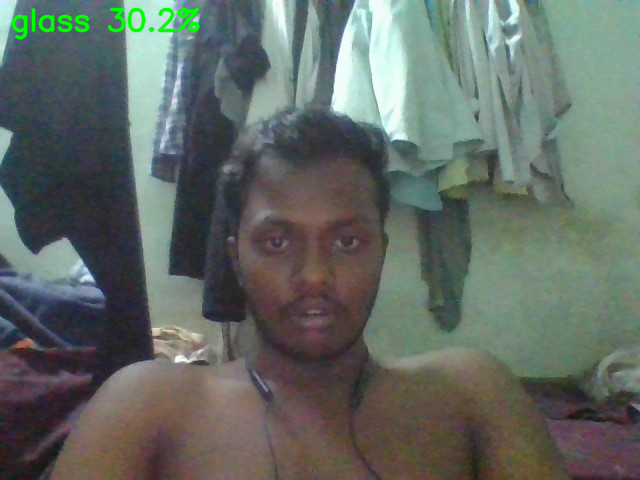

In [31]:
# Colab: single-shot live capture -> analyze -> display
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import Javascript, display
import tensorflow as tf
import numpy as np
import cv2, base64, os, time

# --- USER: set your model path here ---
model_path = '/content/waste_classifier/waste_classifier.keras'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at: {model_path}. Update model_path variable.")

# Load model
model = tf.keras.models.load_model(model_path)
print("Model loaded. input_shape:", model.input_shape)

# Derive preprocessing params from model
inp = model.input_shape
if isinstance(inp, list):
    inp = inp[0]
if len(inp) == 4:
    _, H, W, C = inp
elif len(inp) == 3:
    H, W, C = inp
else:
    H, W, C = 150,150,3
H = int(H or 150); W = int(W or 150); C = int(C or 3)
print(f"Preprocess -> {H}x{W}, channels={C}")

# CLASS LABELS (update if training mapping differs)
CLASS_LABELS = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'plastic'}

def js_capture_once(quality=0.8):
    js = f"""
    async function captureOnce(quality) {{
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      capture.style = 'font-size:16px; padding:6px 10px; margin:6px';
      div.appendChild(capture);
      document.body.appendChild(div);

      const video = document.createElement('video');
      video.style.width = '480px';
      video.style.height = '360px';
      div.insertBefore(video, capture);

      const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for click
      await new Promise((resolve) => capture.onclick = resolve);

      // Draw frame to canvas and stop stream
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }}
    captureOnce({quality});
    """
    return eval_js(js)

def save_dataurl_to_file(dataurl, filename='captured.jpg'):
    header, encoded = dataurl.split(',', 1)
    binary = base64.b64decode(encoded)
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_bgr_for_model(img_bgr):
    # Convert BGR->RGB if model expects 3 channels; handle grayscale if C==1
    if C == 3:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    elif C == 1:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
    if C == 1:
        img = np.expand_dims(img, axis=-1)
    x = img.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    return x

print("Ready — press the Capture button that will appear below when you run capture_once().")

# --- Capture once, analyze, display (call this cell repeatedly to take more photos) ---
dataurl = js_capture_once(quality=0.9)   # opens camera preview + Capture button
filename = save_dataurl_to_file(dataurl, 'captured.jpg')
print("Saved capture to:", filename)

# Read image and show
img = cv2.imread(filename)
if img is None:
    raise RuntimeError("Failed to read saved image.")

# Preprocess and predict
x = preprocess_bgr_for_model(img)
preds = model.predict(x, verbose=0)

# Interpret predictions robustly
preds_arr = np.asarray(preds)
if preds_arr.ndim == 2 and preds_arr.shape[1] > 1:
    probs = tf.nn.softmax(preds_arr[0]).numpy()
elif preds_arr.size == 1:
    p = float(preds_arr.flatten()[0])
    probs = np.array([1-p, p])
else:
    # flatten vector
    probs = preds_arr.flatten()
    if probs.size > 1:
        # try softmax to make readable
        try:
            probs = tf.nn.softmax(probs).numpy()
        except Exception:
            pass

num_classes = probs.shape[0]
idx = int(np.argmax(probs))
label = CLASS_LABELS.get(idx, f'Class_{idx}')
confidence = float(probs[idx]) if idx < len(probs) else 0.0

print(f"Predicted: {label}  (confidence: {confidence*100:.1f}%)  — model outputs {num_classes} classes")

# Annotate and display
annot = img.copy()
cv2.putText(annot, f'{label} {confidence*100:.1f}%', (10,30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(annot)


Final